In [1]:
import pandas as pd

# Reading survey from XLSX
root = "G:\\Me\\Code\\UOC\\TFM\\demeter\\data\\survey\\"
inputs = root + "inputs\\"
outputs = root + "outputs\\"

file_name = inputs + "FAQ.xlsx"
xls = pd.ExcelFile(file_name) 
sheet = xls.parse("Form Responses 1")

#file_name = inputs + "FAQ.csv"
#sheet = pd.read_csv(file_name, encoding = 'ISO-8859-1')

sheet.columns = ["timestamp","country","age","social_network","profile","cultivars","places","forecast_precipitation","climatology","forecast_yield","forecast_date"]


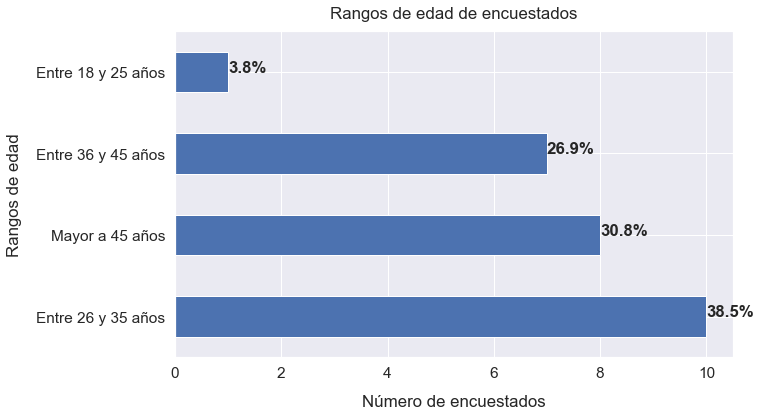

In [116]:
# Descriptive analysis

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sns.set(font_scale=1.4)
dfd = sheet

# Age analysis
bar,ax = plt.subplots(figsize=(10,6))
ax = dfd['age'].value_counts().plot(kind='barh') #dfd['age'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Número de encuestados", labelpad=14)
plt.ylabel("Rangos de edad", labelpad=14)
plt.title("Rangos de edad de encuestados", y=1.02)
# calculate the percentages
for rect in ax.patches:    
    ax.text (rect.get_width(),rect.get_y() + rect.get_height() / 2,"%.1f%%"% ((rect.get_width()/26)*100), weight='bold' )

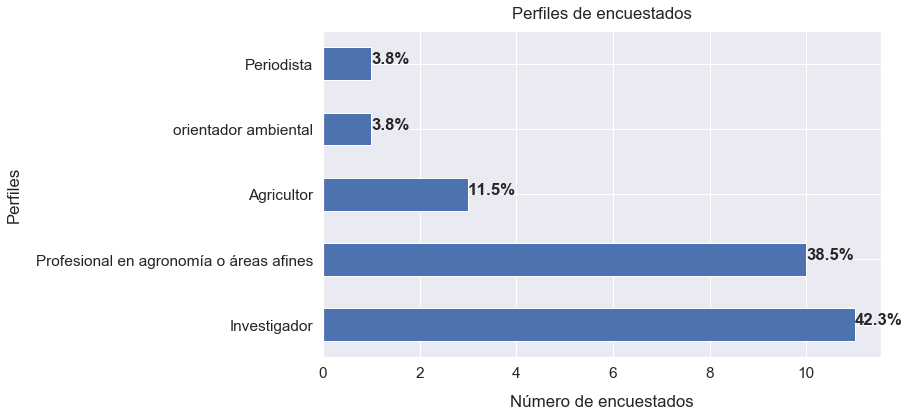

In [117]:
bar,ax = plt.subplots(figsize=(10,6))
ax = dfd['profile'].value_counts().plot(kind='barh') #dfd['profile'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Número de encuestados", labelpad=14)
plt.ylabel("Perfiles", labelpad=14)
plt.title("Perfiles de encuestados", y=1.02)
# calculate the percentages
for rect in ax.patches:    
    ax.text (rect.get_width(),rect.get_y() + rect.get_height() / 2,"%.1f%%"% ((rect.get_width()/26)*100), weight='bold' )

Text(0.5, 1.02, 'Redes sociales usadas por los encuestados')

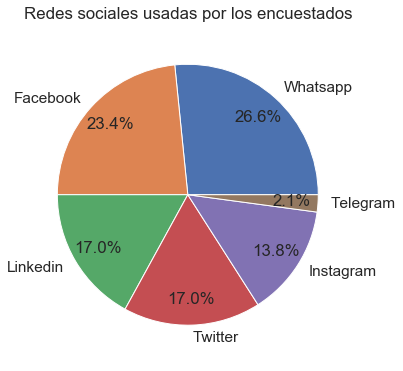

In [140]:
dfs = pd.DataFrame()
dfd2 = [x.split(',') for x in dfd['social_network']]
for c in dfd2:
    dfs = dfs.append(c, ignore_index=True)
dfs.columns = ["social_network"]
dfs = trim_all_columns(dfs)
bar,ax = plt.subplots(figsize=(10,6))
ax = dfs["social_network"].value_counts().plot(kind='pie',autopct="%.1f%%", pctdistance=.8) #dfd['profile'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.ylabel("")
plt.title("Redes sociales usadas por los encuestados", y=1.02)


In [42]:
# Spliting columns intents by comma
df = pd.DataFrame()
split_comma = lambda x: pd.Series([i for i in reversed(x.split(','))])
for c in ["cultivars","places","forecast_precipitation","climatology","forecast_yield","forecast_date"]:
    print ("Processing " + c)
    df2 = sheet[c].apply(split_comma)
    for c2 in df2.columns:     
        tmp = df2[c2]
        tmp = tmp.dropna()
        tmp = tmp.to_frame()
        tmp["intent"] = c
        tmp.columns = ["question","intent"]
        df = df.append(tmp, ignore_index=True)
        
print (df.head())
df.to_csv(outputs +'01-intents.csv', index = False, encoding='utf-8-sig')

Processing cultivars
Processing places
Processing forecast_precipitation
Processing climatology
Processing forecast_yield
Processing forecast_date
                                            question     intent
0                    cuales son tipos de variedades?  cultivars
1   ¿los modelos tienen en cuenta el tipo de vari...  cultivars
2                                                     cultivars
3           ¿dónde puedo conseguir estos materiales?  cultivars
4  Que variedades de arroz se puede sembrar en la...  cultivars


In [54]:
# Cleaning records

def trim_all_columns(df):
    trim_strings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trim_strings)

# replace all enters inside of the text
df2 = df.replace(r'\\n',' ', regex=True) 
df2 = df.replace(r'  ',' ', regex=True) 
# Remove blank spaces starting and ending inside of the text
df2 = trim_all_columns(df2)
# Remove quotes
df2["question"] = df2["question"].str.replace('"', '')
# Count number of words in each intent
df2["n_words"]  = df2['question'].str.split().str.len()
# Saving output
df2.to_csv(outputs +'02-intents.csv', index = False, encoding='utf-8-sig')

In [65]:
# Filtering data
df3 = df2.loc[df2["n_words"] > 2,:]
# Adding field for useable records
df3['useable'] = 1
df3.to_csv(outputs +'03-intents.csv', index = False, encoding='utf-8-sig')

C:\Users\hsotelo\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [64]:
# Spliting columns each word by space
df4 = df3.loc[:,["question","intent","useable"]]
df4['question'] = [':O '.join(x.split()) for x in df4['question']]
df4['question'] = df4['question'] + ":O"
print (df4.head())
df4.to_csv(outputs +'04-intents.csv', index = False, encoding='utf-8-sig')

                                            question     intent  useable
0          cuales:O son:O tipos:O de:O variedades?:O  cultivars        1
1  ¿los:O modelos:O tienen:O en:O cuenta:O el:O t...  cultivars        1
3  ¿dónde:O puedo:O conseguir:O estos:O materiale...  cultivars        1
4  Que:O variedades:O de:O arroz:O se:O puede:O s...  cultivars        1
5  ¿afectan:O las:O temperaturas:O minimas:O alta...  cultivars        1


In [19]:
file_name_f = inputs + "Manual-check.xlsx"
xls_f = pd.ExcelFile(file_name_f) 
sheet_f = xls_f.parse("04-intents")
sheet_f = sheet_f.loc[sheet_f["useable"] == 1,["question","intent"]]
sheet_f.to_csv(outputs +'05-intents.csv', index = False, encoding='utf-8-sig')

In [20]:
# Fixing labels and words in differents columns
sheet_f["words"] = ""
sheet_f["labels"] = ""
for i,row in sheet_f.iterrows() :
    q = row["question"]
    sheet_f.at[i,"words"] =" ".join([r.rsplit(":", 1)[0] for r in [w for w in q.split() ]])
    sheet_f.at[i,"labels"] =" ".join([l.rsplit(":", 1)[1] for l in [w for w in q.split() ]])

sheet_f.to_csv(outputs +'06-intents_labels.csv', index = False, encoding='utf-8-sig')
print(sheet_f.head())

                                            question     intent  \
0          cuales:O son:O tipos:O de:O variedades?:O  cultivars   
1  ¿los:O modelos:O tienen:O en:O cuenta:O el:O t...  cultivars   
2  ¿dónde:O puedo:O conseguir:O estos:O materiale...  cultivars   
3  Que:O variedades:O de:O arroz:B-crop se:O pued...  cultivars   
4  Cuál:O variedad:O es:O más:O recomendable:O en...  cultivars   

                                               words  \
0                    cuales son tipos de variedades?   
1  ¿los modelos tienen en cuenta el tipo de varie...   
2           ¿dónde puedo conseguir estos materiales?   
3  Que variedades de arroz se puede sembrar en la...   
4  Cuál variedad es más recomendable en San André...   

                                              labels  
0                                          O O O O O  
1                                  O O O O O O O O O  
2                                          O O O O O  
3     O O O B-crop O O O O O B-locality 

In [21]:
# Adding some calculations
dft = sheet_f
dft["length"] = dft['words'].str.split().str.len()

In [22]:
dft.groupby("intent").count()

,question,words,labels,length
intent,,,,
climatology,64,64,64,64
cultivars,73,73,73,73
forecast_date,72,72,72,72
forecast_precipitation,89,89,89,89
forecast_yield,78,78,78,78
places,69,69,69,69


,question,intent,words,labels,length
0,cuales:O son:O tipos:O de:O variedades?:O,cultivars,cuales son tipos de variedades?,O O O O O,5
1,¿los:O modelos:O tienen:O en:O cuenta:O el:O t...,cultivars,¿los modelos tienen en cuenta el tipo de varie...,O O O O O O O O O,9
2,¿dónde:O puedo:O conseguir:O estos:O materiale...,cultivars,¿dónde puedo conseguir estos materiales?,O O O O O,5
3,Que:O variedades:O de:O arroz:B-crop se:O pued...,cultivars,Que variedades de arroz se puede sembrar en la...,O O O B-crop O O O O O B-locality O I-locality,12
4,Cuál:O variedad:O es:O más:O recomendable:O en...,cultivars,Cuál variedad es más recomendable en San André...,O O O O O O B-locality I-locality I-locality I...,10


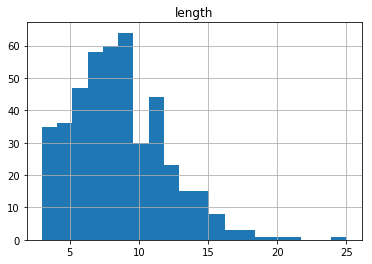

In [23]:
dft.hist("length", bins=20);
dft.head()

In [24]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(dft.loc[:,["question","words","labels","length"]],dft["intent"],test_size=0.3,train_size=0.7)
x["intent"] = y
x_test["intent"] = y_test
x.to_csv(outputs +'07-train.csv', index = False, encoding='utf-8-sig')
x_test.to_csv(outputs +'07-test.csv', index = False, encoding='utf-8-sig')
#x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [25]:
print(x.shape)
print(y.shape)

(311, 5)
(311,)
